## Introduction

In this note we would like to explain two concepts.
* How to choose best models.
* What __Multiple Linear Regression__ is. 

Here we will explain why spliting the dataset may not be enough and we introduce train-dev-test sliting.

## Diabetes dataset

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets

In [2]:
matplotlib.rcParams['figure.figsize'] = [20, 10]

In [3]:
diabetes = datasets.load_diabetes()

## Problem

__Main Question__ Which model is better?
1. Model that predict disease progression based on body mass.
2. Model that predict disease progression based on all 10 features.

## Multiple Linear Regression

In order to predict disease progression based on all 10 features we will build a model called Multiple Linear Regression. 

__Multiple Linear Regression__ is a model that have $n+1$ parameters $a_0$, $a_1$,... $a_n$ and $b$ and has the form:

$$\hat{y} = a_0x_0 + a_1x_1 + \ldots + a_nx_n + b$$

Recall that, in our case, we have the following 10 variables:
    * $x_0$: age, 
    * $x_1$: sex, 
    * $x_2$: body mass index, 
    * $x_3$: average blood pressure, 
    * $x_4$, $x_5$, $x_6$, $x_7$, $x_8$, $x_9$: six blood serum measurements.
    
So we have 11 parameters $a_0$, $a_1$, $a_2$, $a_3$, $a_4$, $a_5$, $a_6$, $a_7$, $a_8$, $a_9$ and $b$. So the model has a form:

$$\hat{y} = a_0x_0 + a_1x_1 + a_2x_3 + a_3x_3 + a_6x_6 + a_8x_8 + a_9x_9 + b$$

## Building and testing models

So here we will execute the following steps:

1. Prepare data.
2. Split data into train and test.
3. Build a models and further data preparation for each model.
4. Fit models to train data on selected columns.
5. Evaluate models on test data and compare performance.

#### 1. Prepare data

Since the second model uses all columns our $X$ is simply entire dataset. When we will train model we will do further data selection.

In [4]:
X = diabetes.data
y = diabetes.target

#### 2. Split data into train and test.

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=666, test_size=0.1)

#### 3. Build a models

In [6]:
from sklearn.linear_model import LinearRegression
reg1 = LinearRegression()
reg2 = LinearRegression()

#### 4. Fit models to train data on selected columns.

In [7]:
reg1.fit(X_train[:, [2]], y_train) # here we choose only second column
reg2.fit(X_train, y_train) # here we take all possible variables

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

#### 5. Evaluate models on test data and compare performance.

In [8]:
from sklearn.metrics import mean_squared_error, r2_score
y_test_hat1 = reg1.predict(X_test[:, [2]])
y_test_hat2 = reg2.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_test_hat1)), np.sqrt(mean_squared_error(y_test, y_test_hat2))

(55.85346157514181, 47.61322195051475)

### Conclusion

We have seen that the model based on all variables has better perfomance than the model based just on one variable. However, in what follows we will see that there is actually a better choice of variables. We will try to find them by considering all possible combinations of colums.

## All possible combinations of columns

We will again execute the same steps, but this time we choose all combinations columns. This will give us lots of models to test.

1. Prepare data.
2. Split data into train and test.
3. Build a models and further data preparation for each model.
4. Fit models to train data on selected columns.
5. Evaluate models on test data and compare performance.

In [9]:
from itertools import combinations

# 1. Prepare data.
X = diabetes.data
y = diabetes.target

# 2. Split data into train and test.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=666, test_size=0.2)

# 3. Build a models and further data preparation for each model.
# 4. Fit models to train data on selected columns.
# 5. Evaluate models on test data and compare performance.

def fit_and_evaluate(columns, X_train, X_test, y_test):
    """
    Function that evaluate how model train on specific combination of columns performs
    
    columns: variable that that contains a list of columns that we use to train a particular model
    X_train: Dataset that we use to train the model
    X_test: Dataset that we use to test the model
    y_test: true predictions for test dataset
    
    returns: root means square error evaluated on test dataset
    """
    # Build the model
    reg = LinearRegression()
    
    # Fit the model to dataset with specific columns
    reg.fit(X_train[:, columns], y_train)
    
    # Evaluate models on test data.
    y_test_hat = reg.predict(X_test[:, columns])
    return np.sqrt(mean_squared_error(y_test, y_test_hat))

def get_performance_on_combinations_of_columns(X_train, X_test, y_test):
    """
    Function that generate all combination of columns
    and then evaluate how model train on that combinations performs
    
    X_train: Dataset that we use to train the model
    X_test: Dataset that we use to test the model
    y_test: true predictions for test dataset
    
    returns: DataFrame with
        - number of columns used
        - specific combination of columns
        - root means square error evaluated on test dataset
    """
    all_columns_num = X_train.shape[1]
    all_colnames = list(range(all_columns_num))
    
    performance = pd.DataFrame(
        columns=["n_columns", "columns", "RMSE"]
    )

    for columns_num in range(1, all_columns_num + 1):
        for columns in combinations(all_colnames, columns_num):
            rmse = fit_and_evaluate(columns, X_train, X_test, y_test)
            new_row = pd.DataFrame({
                "n_columns": [columns_num], 
                "columns": [columns], 
                "RMSE": [rmse]
            })
            performance = performance.append(new_row, ignore_index = True)  
    return performance

In [10]:
performance = get_performance_on_combinations_of_columns(X_train, X_test, y_test) 
        
print("Total number of non-empty combination is {}.".format(len(performance)))

Total number of non-empty combination is 1023.


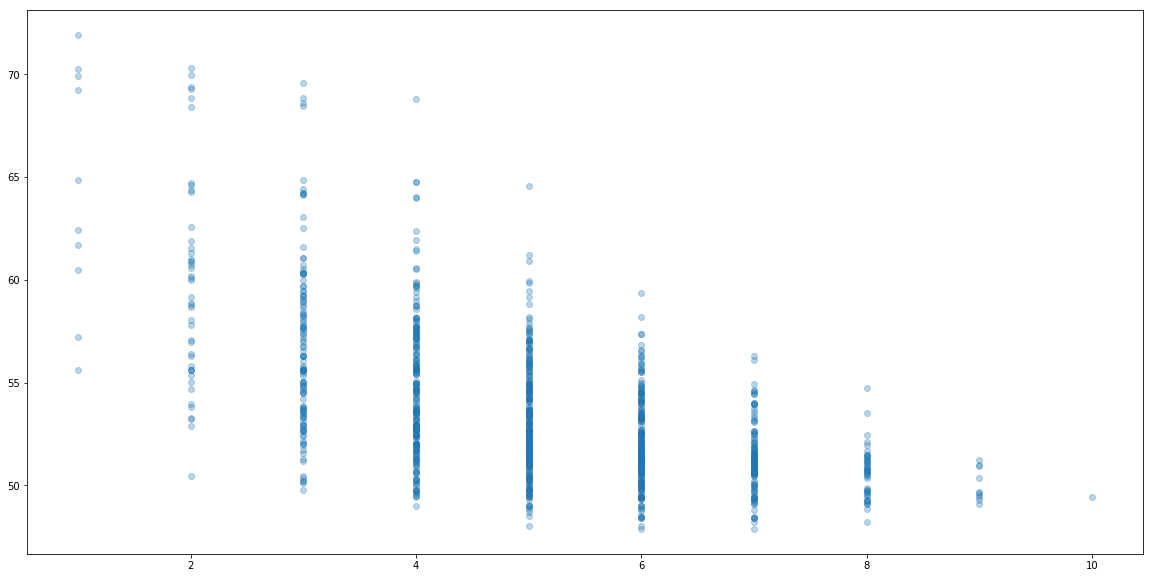

In [11]:
plt.scatter(performance["n_columns"], performance["RMSE"], alpha = 0.3)

In [12]:
# Best performing models

performance.sort_values("RMSE").head()

,n_columns,columns,RMSE
781,6,"(1, 2, 3, 6, 8, 9)",47.880858
865,7,"(0, 1, 2, 3, 6, 8, 9)",47.889001
521,5,"(1, 2, 3, 6, 8)",48.020136
647,6,"(0, 1, 2, 3, 6, 8)",48.038394
981,8,"(0, 1, 2, 3, 6, 7, 8, 9)",48.210301


So the best choice of columns are columns: `(1, 2, 3, 6, 8, 9)`. Let's see what they are.

In [13]:
[diabetes.feature_names[i] for i in [1, 2, 3, 6, 8, 9]]

['sex', 'bmi', 'bp', 's3', 's5', 's6']

Text(0,0.5,'Errors')

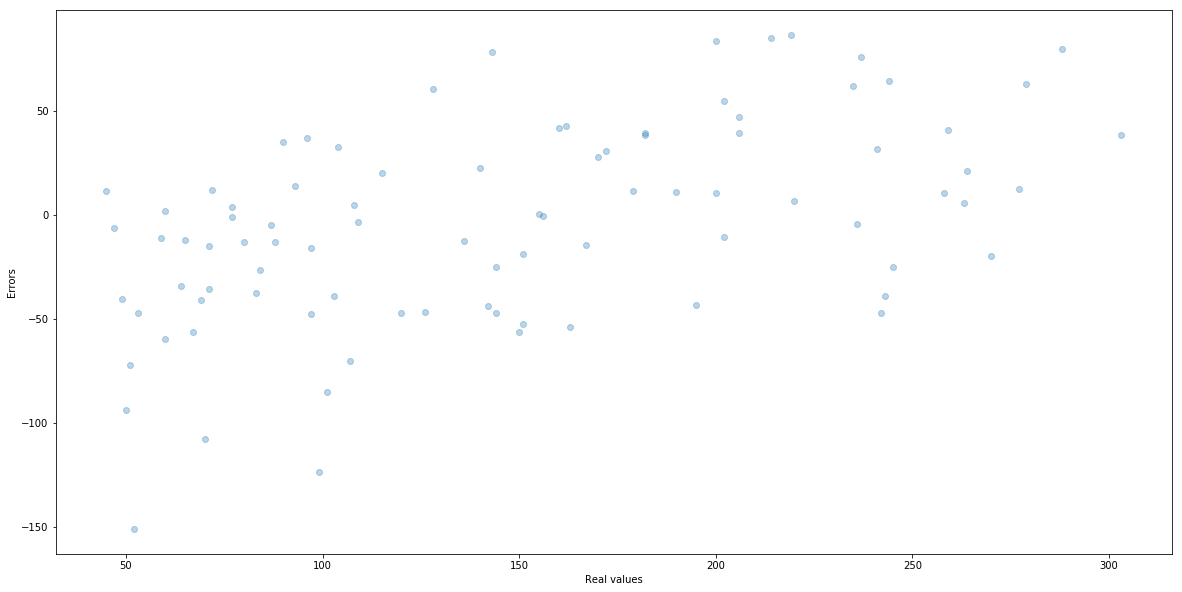

In [14]:
best_reg = LinearRegression()
best_reg.fit(X_train[:, (1, 2, 3, 6, 8, 9)], y_train)
y_test_hat = best_reg.predict(X_test[:, (1, 2, 3, 6, 8, 9)])
plt.scatter(y_test, y_test-y_test_hat, alpha = 0.3)
plt.xlabel("Real values")
plt.ylabel("Errors")

In [15]:
best_reg.coef_

array([-225.78647725,  533.21599131,  319.5160069 , -293.65810211,
        491.19212091,   35.45789137])

## Hyperparameters and train-dev-test split

Let us recall that by __parameters__ we understand coeficients of our model. In the case of our best model we have 7 parameters:

$$\hat{y} = a_1x_1 + a_2x_3 + a_3x_3 + a_6x_6 + a_8x_8 + a_9x_9 + b$$

where $a_1, a_2, a_3, a_6, a_8, a_9$ are

In [16]:
best_reg.coef_

array([-225.78647725,  533.21599131,  319.5160069 , -293.65810211,
        491.19212091,   35.45789137])

and $b$ (called also bias) is

In [17]:
best_reg.intercept_

153.00353416418773

However, as we have said before we have also another kind of parameters that are actully our choice of colums. Those are called __hyperparameters__. In order to find them we have also done some fitting. We have taken 1023 combinations and see which one has performed best on our test dataset. This is not very scientific, since we use this set to report final performance of our fitted model. Therefore we introduce further spliting of train set into validation set. 


1. Prepare data. 
2. Split data into train,  dev and test.
3. Build models, fit them to train dataset and evaluate on dev dataset.
4. Choose the hyperparameters of the model that performs best on dev.
5. Build and fit the model with these hyperparameters to both train and dev datasets.
5. Evaluate the best model performance of test.

In [18]:
# 1. Prepare data.
X = diabetes.data
y = diabetes.target
# 2. Split data into train,  dev and test.
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, random_state=666, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=667, test_size=0.25)

In [19]:
len(y_train), len(y_val), len(y_test)

(264, 89, 89)

In [20]:
# 3. Build models, fit them to train dataset and evaluate on dev dataset.

performance = get_performance_on_combinations_of_columns(X_train, X_val, y_val) 
performance.sort_values("RMSE").head()

,n_columns,columns,RMSE
765,6,"(1, 2, 3, 4, 5, 8)",56.184161
932,7,"(1, 2, 3, 4, 5, 6, 8)",56.211273
849,7,"(0, 1, 2, 3, 4, 5, 8)",56.262737
968,8,"(0, 1, 2, 3, 4, 5, 6, 8)",56.297644
936,7,"(1, 2, 3, 4, 5, 8, 9)",56.301163


In [21]:
# 4. Choose the hyperparameters of the model that performs best on dev.
best_columns = (1, 2, 3, 4, 5, 8)

# 5. Build and fit the model with these hyperparameters to both train and dev datasets.
c = LinearRegression()
best_reg.fit(X_train[:, best_columns], y_train)
y_test_hat = best_reg.predict(X_test[:, best_columns])
np.sqrt(mean_squared_error(y_test, y_test_hat))

48.79549385587892

## Exercises: Boston dataset

In this exercise we will use Boston Dataset to answer the following question.

__Question__ What is the best choice of columns for linear model of median value of owner-occupied homes?

Here we have the data set.

In [22]:
from sklearn.datasets import load_boston
boston = load_boston()